In [1]:
import cv2 as cv
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
from skimage import data

* [paper](http://matthewalunbrown.com/papers/ijcv2007.pdf)
* [OpenPano](https://github.com/ppwwyyxx/OpenPano)


### Overall Process

##### SIFT ( Scale Invariant Feature Transform )
This step aims to find unique keypoints in each image. These keypoints should stay unique even if the scale of the images changes hence they are called scale invariant.


 1) Detection of scale-space extrema.
    * Detect keypoints using a DOG (Difference of Gaussian) filter to identify candidate locations. generate multiple scaled versions of the image and apply different level of gaussian to all scaled versions.
    * search for local maximum and minimum.
    * The detected local extremas at each scale.

 2) Accurate keypoint localization.
    * For each local extrema, we need to check its Hessian value from the Gaussian smoothed image at the corresponding scale. The purpose here is to eliminate edge responses.
    * After thresholding the detected extrema, the remaining local extrema will be used as key points.

 3) Dominant orientation assignment
    * Create histogram of local gradient directions computed at selected scale of Gaussian pyramid.
    * Each sample added to the histogram is weighted by its gradient magnitude and by a Gaussian-weighted circular window.
    * The highest two peaks in the orientation histogram are detected.

##### -- More detailed info here --
http://aishack.in/tutorials/sift-scale-invariant-feature-transform-log-approximation/

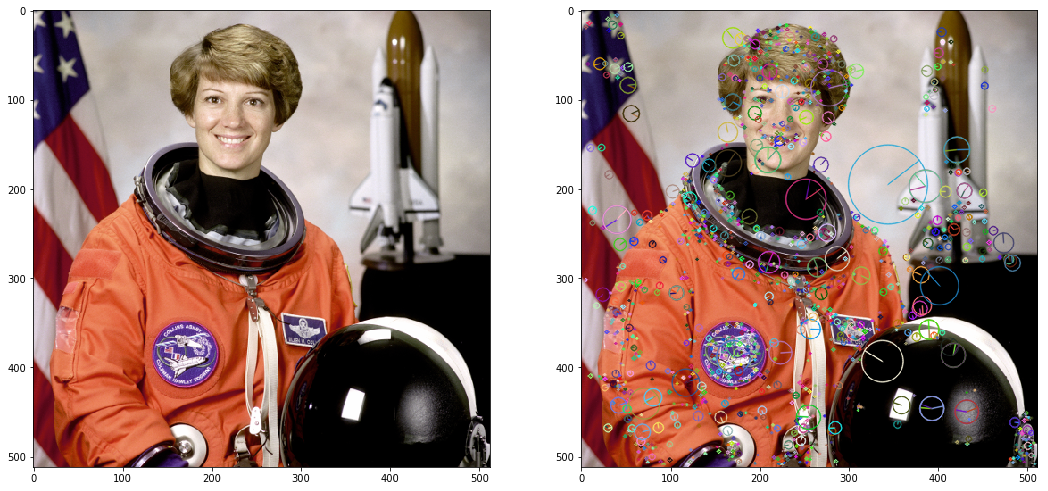

In [2]:
# EXAMPLE USING OPENCV

# setting up plotting
fig = plt.figure(figsize=(18,12))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

# sample image
img = data.astronaut()
img_with_keypoints = data.astronaut()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## extracting features ##
# Step 1 related params -- create scale/space
NUM_OCTAVE = 4 # num of octave layers
GAUSS_SIGMA = 1.4142135623 # gaussian blur sigma
CONTRAST_THRES = 4e-2 # threshold for contrast in difference of octave layers
# NUM_SCALE -- num of scaling of octaves
# GAUSS_WINDOW_FACTOR -- gaussian kernel size
# SCALE_FACTOR

# Step 2 related params -- find local extremas
# EDGE_RATIO -- https://en.wikipedia.org/wiki/Hessian_matrix curvature ratio
# JUDGE_EXTREMA_DIFF_THRES
# PRE_COLOR_THRES
# CALC_OFFSET_DEPTH
# OFFSET_THRES

# Step 3 related params -- Dominant oriantation assignment
# ORI_RADIUS -- orientation radius
# ORI_HIST_SMOOTH_COUNT -- histogram smoothing
# DESC_HIST_SCALE_FACTOR
# DESC_INT_FACTOR


sift = cv.xfeatures2d.SIFT_create(
    nOctaveLayers=NUM_OCTAVE,
    contrastThreshold=CONTRAST_THRES,
    sigma=GAUSS_SIGMA
)
kp = sift.detect(gray, None)


# draw plots
cv.drawKeypoints(
    img,
    kp,
    img_with_keypoints,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

ax1.imshow(img)
ax2.imshow(img_with_keypoints)
plt.show()

# Uncomment for more info
# help(cv.xfeatures2d.SIFT_create)

## keypoints with different sizes and oriantations

##### RANSAC
This step aims to find features that are repeated among the neighbour images that are goint to be stitched together


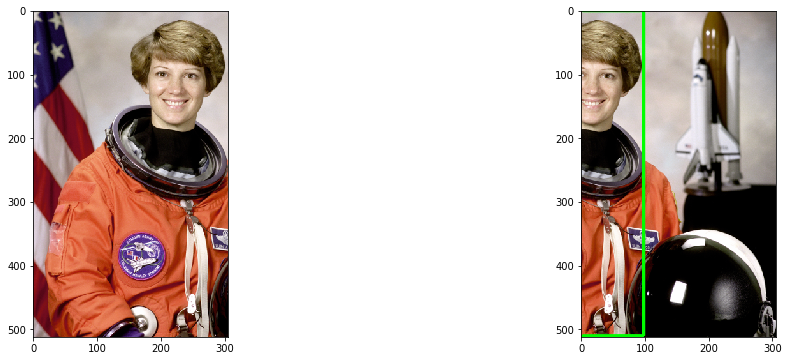

In [3]:
# setting up plotting
fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

# cut astranout into two
# we will stitch her together later on...
ast_size_x, ast_size_y, _ = data.astronaut().shape
ast_left_part = data.astronaut()[:, :round(ast_size_x / 2 + 50)]
ast_right_part = data.astronaut()[:, round(ast_size_x / 2 - 50):]

gray_left = cv.cvtColor(ast_left_part, cv.COLOR_BGR2GRAY)
gray_right = cv.cvtColor(ast_right_part, cv.COLOR_BGR2GRAY)

sift = cv.xfeatures2d.SIFT_create()
kp_left, des_left = sift.detectAndCompute(gray_left, None)
kp_right, des_right = sift.detectAndCompute(gray_right, None)


# setup Flann matcher -- this is supposedly what they use in the paper...
# section:  3.2 Probabilistic Model for Image Match Verification
FLANN_INDEX_KDTREE = 0 # flann based matching algorithm
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)


# find matches
matches = flann.knnMatch(des_left, des_right, k=2)


# we need to test the matches against a threshold value
# RANSAC_ITERATIONS
# RANSAC_INLIER_THRES
RANSAC_INLIER_THRES = 0.7
good = []
for m,n in matches:
    if m.distance < RANSAC_INLIER_THRES * n.distance:
        good.append(m)


# we need to set a minimum match count.
# if match count falls unders this value we
# assume they cannot be stitched together
# -- OpenPano uses match ratios instead of hardcoded count
# INLIER_IN_MATCH_RATIO
# INLIER_IN_POINTS_RATIO 
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp_left[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_right[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()
    
    h, w, _ = ast_left_part.shape
    pts = np.float32([[[0,0], [0,h-1], [w-1,h-1],[w-1,0]]]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts, M)

    # rectangle the part that matches
    ast_right = cv.polylines(ast_right_part, [np.int32(dst)], True, (0,255,0), 3, cv.LINE_AA)
else:
    print ('Image cannot be stitched')


ax1.imshow(ast_left_part)
ax2.imshow(ast_right)

plt.show()

# matching part on right image.

#### Homography -- stitching images together


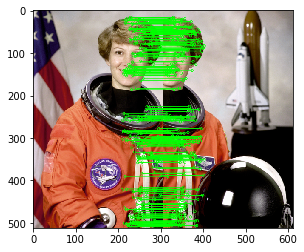

In [4]:
ast_size_x, ast_size_y, _ = data.astronaut().shape
ast_left = data.astronaut()[:, :round(ast_size_x / 2 + 50)]
ast_right = data.astronaut()[:, round(ast_size_x / 2 - 50):]

draw_params = dict(matchColor=(0,255,0),
                  singlePointColor=None,
                  matchesMask=matches_mask,
                  flags=2)

draw_matches = cv.drawMatches(ast_left ,kp_left,
                       ast_right ,kp_right,
                       good,
                       None,
                       **draw_params)


plt.imshow(draw_matches, 'gray')
plt.show()

##### Gain Compensation -- smoothing out exposure differences
##### Blending -- Making seams less noticable